<a href="https://colab.research.google.com/github/Ilyaas189/Text-Analytics_CE_807/blob/main/topic_modeling_iteration_Two_30_to_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
# import libraries
import re
import gensim
import numpy as np
from gensim import models
from gensim import corpora
from string import punctuation
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from collections import defaultdict
from gensim.corpora import Dictionary
from nltk.stem.porter import PorterStemmer
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
from sklearn import preprocessing
from gensim.models import CoherenceModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

### Data Pre-Processing

In [ ]:
# extract 20newsgroup dataset
newsgroups = fetch_20newsgroups()

In [ ]:
print("All attributes in dataset:......."    ,len(newsgroups.keys()))
print("-----------------------------------\n")
print("All attributes names in dataset:.......", (newsgroups.keys()))
print("-----------------------------------\n")
print("Total number of classes:.........",len(np.unique(newsgroups['target_names'])))
print("-----------------------------------\n")
print("All unique classes:.......",np.unique(newsgroups['target_names']))
print("-----------------------------------\n")
print("Total number of instances in daataset:.........", len(newsgroups['data']))
print("-----------------------------------\n")



All attributes in dataset:....... 5
-----------------------------------

All attributes names in dataset:....... dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
-----------------------------------

Total number of classes:......... 20
-----------------------------------

All unique classes:....... ['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']
-----------------------------------

Total number of instances in daataset:......... 11314
-----------------------------------



In [ ]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

# initialize a list of standard nltk stopwords for english language
eng_stopwords = stopwords.words('english')
# extend stopwords list to add more words that are in our dataset
eng_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])
# initialize tokenizer
tokenizer = RegexpTokenizer(r'\s+', gaps=True)
# initialize porter stemmer
stemmer = PorterStemmer()
# initialize all english punctuation marks
translate_tab = {ord(p): u" " for p in punctuation}

# make a method to clean data
def text2tokens(raw_text):
    """Split the raw_text string into a list of stemmed tokens."""
    # remove email ids
    clean_text = re.sub('\S*@\S*\s?', '', raw_text)
    # remove single quotes
    clean_text = re.sub("\'", "", clean_text)
    # lowercase letters and remove punctuations
    clean_text = clean_text.lower().translate(translate_tab)
    # tokenize data and remove extra spaces
    tokens = [token.strip() for token in tokenizer.tokenize(clean_text)]
    # remove stopwords
    tokens = [token for token in tokens if token not in eng_stopwords]
    # perform stemming on data
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # skip short tokens
    return [token for token in stemmed_tokens if len(token) > 2] 

# convert all documents in dataset to list of tokens
dataset = [text2tokens(txt) for txt in newsgroups['data']]  
print("Data Pre-Processing Done.....!")

Data Pre-Processing Done.....!


### Build Dictionary

In [ ]:
# make dictionary of complete dataset
dictionary = Dictionary(documents=dataset, prune_at=None)
# use Dictionary to remove un-relevant tokens
dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n=None)  
dictionary.compactify()
# make unigrams
d2b_dataset = [dictionary.doc2bow(doc) for doc in dataset]
print("Build Dcitionary Done....!")

Build Dcitionary Done....!


### Find optimal value of alpha and beta

In [ ]:
# list of number of topics
topics = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170]
# Alpha parameter
alpha = [0.001,0.1]
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = [0.1,1.0,10.0]

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for topic_num in topics:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            lda_model = models.LdaModel(corpus=d2b_dataset,
                                           id2word=dictionary,
                                           num_topics=topic_num, 
                                           random_state=100,
                                           chunksize=500,
                                           passes=2,
                                           alpha=a,
                                           eta=b)
    
            coherence_model_lda = CoherenceModel(model=lda_model, texts=dataset, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model_lda.get_coherence()
            
            
            model_results['Topics'].append(topic_num)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(coherence_score)

### Train - Test split with 80:20 ratio
### Further 10% from train data will be used for tuning. We will be using kfold cross validation where 10 number of splits will be created and at each step one part of data will be used for tuning and other will be for training


### Make object of classification model

In [ ]:
# make model object
lr = LogisticRegression(class_weight= 'balanced',solver='newton-cg',fit_intercept=True)

### Find optimal number of topics using classification

In [ ]:
# list of number of topics
topics = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
acc_list_train = []
acc_list_valid = []
acc_list_test = []

# iterate over all number of topics
for topic_num in topics:
    # build and fit lda model on dataset
    lda_model = models.LdaModel(d2b_dataset, num_topics=topic_num, id2word=dictionary,chunksize=500, passes=2, alpha=[0.01]*topic_num, eta=[1.0]*len(dictionary.keys()))
    train_vecs = []
    # make feature vectors of topics extracted from lda model
    for i in range(len(d2b_dataset)):
        # make sure all values are present also keep te values having 0 probability
        top_topics = lda_model.get_document_topics(d2b_dataset[i], minimum_probability=0.0)
        # retrieve all present topics
        topic_vec = [top_topics[x][1] for x in range(topic_num)]
        train_vecs.append(topic_vec)
    # convert input data feature vectors into array
    x_scaled = np.array(train_vecs)
    y = newsgroups['target']
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

    
    # perform cross validation where number of folds = 10
    # shuffle and split dataset into 5 folds
    CV = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=0).split(x_train, y_train))
    # evaluate model using accuracy and f1 measure on held-out dataset
    scores_list_train = []
    scores_list_valid = []
    for train,valid in CV:
        # fit model on train data
        clf = lr.fit(x_train[train],y_train[train])
        # make predictions on validation data
        pred_train = clf.predict(x_train[train])
        pred_valid = clf.predict(x_train[valid])
        # calculate accuracy
        scores_list_train.append(accuracy_score(y_train[train], pred_train))
        scores_list_valid.append(accuracy_score(y_train[valid], pred_valid))
        
    pred_test = clf.predict(x_test)
        # calculate accuracy
    acc_list_test.append(accuracy_score(y_test, pred_test))
    acc_list_train.append(np.array(scores_list_train).mean())
    acc_list_valid.append(np.array(scores_list_valid).mean())
print("Training and Testing Done....")


Training and Testing Done....


In [ ]:
import pandas as pd
topic_num = pd.DataFrame(topics)
train_accuracy = pd.DataFrame(acc_list_train)
tune_accuracy = pd.DataFrame(acc_list_valid)
train_res = pd.concat([topic_num, train_accuracy],axis = 1)
tune_res = pd.concat([topic_num, tune_accuracy],axis = 1)
train_res.columns=['No. of Topics','Train Accuracy']
tune_res.columns=['No. of Topics','Tune Accuracy']
train_res

,No. of Topics,Train Accuracy
0,30,0.569722
1,40,0.621613
2,50,0.650069
3,60,0.684565
4,70,0.548337
5,80,0.656134
6,90,0.640899
7,100,0.668275
8,110,0.682552
9,120,0.605348


In [ ]:
tune_res

,No. of Topics,Tune Accuracy
0,30,0.575959
1,40,0.582586
2,50,0.604130
3,60,0.624685
4,70,0.627775
5,80,0.615845
6,90,0.648547
7,100,0.649208
8,110,0.646557
9,120,0.644898


In [ ]:
test_accuracy = pd.DataFrame(acc_list_test)
test_res = pd.concat([topic_num, test_accuracy],axis = 1)
test_res = pd.concat([topic_num, test_accuracy],axis = 1)
test_res.columns=['No. of Topics','Test Accuracy']
test_res

,No. of Topics,Test Accuracy
0,30,0.585948
1,40,0.586832
2,50,0.600972
3,60,0.623509
4,70,0.635882
5,80,0.637649
6,90,0.648696
7,100,0.665488
8,110,0.669023
9,120,0.643836


### Visulaize Results

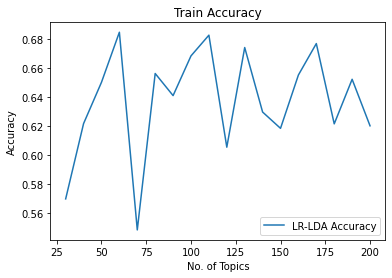

In [ ]:
# plot accuracy scores
limit=100; start=30; step=10;
#topics = range(start, limit, step)
plt.plot(topics, acc_list_train, label='LR-LDA Accuracy')
plt.title('Train Accuracy')
plt.xlabel('No. of Topics')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


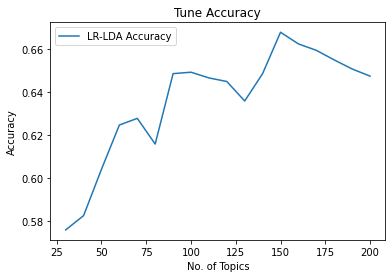

In [ ]:
# plot accuracy scores
limit=100; start=30; step=10;
#topics = range(start, limit, step)
plt.plot(topics, acc_list_valid, label='LR-LDA Accuracy')
plt.title('Tune Accuracy')
plt.xlabel('No. of Topics')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


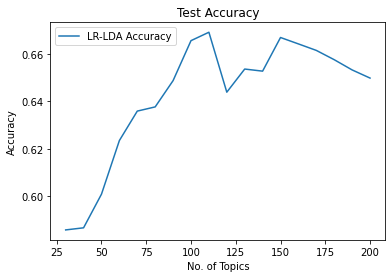

In [ ]:
# plot accuracy scores
limit=100; start=30; step=10;
#topics = range(start, limit, step)
plt.plot(topics, acc_list_test, label='LR-LDA Accuracy')
plt.title('Test Accuracy')
plt.xlabel('No. of Topics')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
